In [2]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
import os
from IPython.display import Video, display

# Create directories
models_dir = "models/PPO"
log_dir = "logs"
video_dir = "video"

os.makedirs(models_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)
os.makedirs(video_dir, exist_ok=True)

print("Setup complete.")

Setup complete.


In [7]:
env_name = "CartPole-v1"

# 1. Create Training Environment
# render_mode=None is faster for training
train_env = gym.make(env_name, render_mode=None)
train_env = Monitor(train_env, log_dir)

# 2. Define the Model
model = PPO(
    policy="MlpPolicy",
    env=train_env,
    verbose=0, # Set to 0 to keep notebook clean, we use TensorBoard instead
    tensorboard_log=log_dir,
    learning_rate=0.0003,
    n_steps=2048
)

print("Training started...")

# 3. Train
# 50,000 steps is usually plenty for CartPole
model.learn(total_timesteps=50000)

print("Training complete.")

# 4. Save
model_path = f"{models_dir}/{env_name}_PPO"
model.save(model_path)
print(f"Model saved to: {model_path}")

Training started...
Training complete.
Model saved to: models/PPO/CartPole-v1_PPO


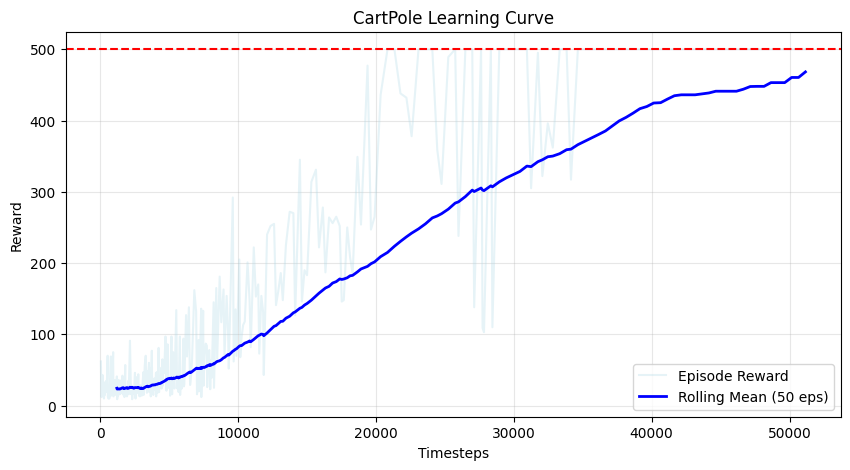

In [8]:
import matplotlib.pyplot as plt
from stable_baselines3.common import results_plotter
import numpy as np

def plot_training_results(log_folder, title="CartPole Learning Curve"):
    """
    Plots the learning curve (reward vs timesteps) from the monitor logs.
    """
    # 1. Get the data frame from the monitor logs
    # results_plotter reads the monitor.csv files generated by the Monitor wrapper
    results_df = results_plotter.load_results(log_folder)
    
    # 2. Extract X (timesteps) and Y (rewards)
    timesteps = results_df.l.cumsum().values
    rewards = results_df.r.values

    # 3. Calculate a rolling average for a smoother line
    # We average over the last 50 episodes to reduce noise
    window_size = 50
    rolling_mean_reward = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
    
    # Adjust timesteps to match the rolling mean size (we lose the first N-1 points)
    rolling_timesteps = timesteps[window_size-1:]

    # 4. Plot using Matplotlib
    plt.figure(figsize=(10, 5))
    
    # Plot raw data (faint light blue) - shows the variance
    plt.plot(timesteps, rewards, color='lightblue', alpha=0.3, label="Episode Reward")
    
    # Plot smoothed data (dark blue) - shows the trend
    plt.plot(rolling_timesteps, rolling_mean_reward, color='blue', linewidth=2, label="Rolling Mean (50 eps)")
    
    plt.xlabel("Timesteps")
    plt.ylabel("Reward")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add a line for the maximum possible reward in CartPole (500)
    plt.axhline(y=500, color='r', linestyle='--', label="Max Reward")
    
    plt.show()

# Execute the plotting function
plot_training_results(log_dir)

In [9]:
# Create a separate evaluation environment
eval_env = gym.make(env_name, render_mode=None)

# Test the agent for 10 episodes
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)

print(f"Mean Reward: {mean_reward} +/- {std_reward}")
# Target: Mean reward should be approx 500.0

c:\Users\leste\miniconda3\envs\RL_tutorial\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean Reward: 500.0 +/- 0.0


In [10]:
# 1. Setup Video Environment
# We trigger recording for the very first episode (lambda x: x == 0)
video_env = gym.make(env_name, render_mode="rgb_array")
video_env = RecordVideo(
    video_env, 
    video_folder=video_dir, 
    name_prefix="cartpole-notebook",
    episode_trigger=lambda x: x == 0,
    disable_logger=True
)

# 2. Run the Episode
obs, info = video_env.reset()
done = False

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = video_env.step(action)
    done = terminated or truncated

video_env.close()

# 3. Display the Video in Jupyter
video_path = f"{video_dir}/cartpole-notebook-episode-0.mp4"

print(f"Displaying video from: {video_path}")
display(Video(video_path, embed=True, html_attributes="controls autoplay loop"))

c:\Users\leste\miniconda3\envs\RL_tutorial\lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\Users\leste\OneDrive - purdue.edu\PhD\1 -- Mahmoudian Lab\Tutorials\PPO\Cart_Pole\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
c:\Users\leste\miniconda3\envs\RL_tutorial\lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Displaying video from: video/cartpole-notebook-episode-0.mp4
